## SUPPLEMENTARY DATA

#### Ancestry-Specific Genetic Risk Score Improves Prediction of Type 1 Diabetes
John S. Kaddis, Ph.D.;  Daniel J. Perry, Ph.D.; Anh Nguyet Vu, B.S.; Stephen S. Rich, Ph.D.; Mark A. Atkinson, Ph.D.; Desmond A. Schatz, M.D.; Bart O. Roep, M.D., Ph.D; Todd M. Brusko, Ph.D.

#### Notebook Dependencies
Code in this notebook relies on the use of SAS Software, which is only accessible through a paid license.  

-If you have SAS, then install the SAS Kernel for Jupyter Notebooks, found here: https://github.com/sassoftware/sas_kernel
<br>-If you do not have access to SAS, there is a free version of it, currently called "SAS OnDemand for Academics: Studio"  You can find out more about that here: https://www.sas.com/en_us/software/on-demand-for-academics/references/getting-started-with-sas-ondemand-for-academics-studio.html

Regardless of your experience with or access to SAS, all of the data files used for this analysis are provided here, including the data derived from SAS.  

### METHODS

#### A. Human Organ Donors
The Network for Pancreatic Organ Donors with Diabetes (nPOD) program coordinates with many organ procurement organizations in the United States to screen and identify potential donors using acceptance criteria posted [here](https://www.jdrfnpod.org/for-partners/opo-recovery).(1) Following acquisition of informed research consent from next of kin, pancreata, related tissues, and blood were obtained from deceased organ donors in the United States.  All donations were then centrally shipped to the nPOD organ processing and pathology core at the University of Florida for biobank sharing, as previously described.(2) All experimental data was acquired under an approval from the University of Florida Institutional Review Board. 

#### B. DNA Isolation and genotyping
DNA from snap-frozen spleen or pancreas tissue was isolated, as previously described.(2) Donors were genotyped at 974,650 unique loci using a custom SNP array termed UFDIchip, as described elsewhere.(3) In brief, the base array consists of the AxiomTM Precision Medicine Research Array (ThermoFisher Scientific), to which all content from the ImmunoChip(4) was added, as well as all previously reported credible T1D risk variants.(5) UFDIchips were processed on an Affymetrix Gene Titan instrument with external sample handling on a BioMek FX dual arm robotic workstation. Data processing and quality control procedures were performed at the SNP, sample, and plate levels using Axiom™ Analysis Suite 3.0 (ThermoFisher Scientific) set to the default stringency thresholds as recommended. An analysis of X chromosome heterozygosity found all samples to be concordant with reported sex. 

#### C. GRS Calculation
EUR GRS was calculated as previously described(6,7) using 26 SNP genotypes extracted from UFDIchip array data and 4 from imputed data. The 4 imputed SNPs were for IL2 (rs2069762, r2 = 0.9962), HLA-A*24 (rs1264813, r2 = 0.9961), INS (rs689, r2 = 0.9486), and UBASH3A (rs3788013, r2 = 0.9967). AFR GRS was calculated as previously described (8) using 4 SNP genotypes extracted from the UFDIchip array and 3 from imputed data.  The 3 imputed SNPs were for rs9271594 (r2 = 0.9498), rs34303755 (r2 = 0.8325), INS (rs689, r2 = 0.9210). The resultant datafiles are provided below. The 1000 Genomes Phase 3 dataset (version 5) was used for imputation.  

In [1]:
/**********************
Two files contain the EUR GRS and AFR GRS data
**********************/

%let location =F:\Manuscripts\2021_06_11_Diab_Care_GRS\submission;


PROC import out=eurgrs datafile = "&location\data\EUR_GRS_nPOD.xlsx"
	DBMS = xlsx replace;
RUN;


PROC import out=afrgrs datafile = "&location\data\AFR_GRS_nPOD.xlsx"
    DBMS = xlsx replace;
RUN;



SAS Connection established. Subprocess id is 14988



#### D. Ancestry Analysis
Ancestry analysis was performed using ADMIXTURE v1.3.(9) The UFDIchip data was first filtered to exclude markers with high linkage disequilibrium and missingness using recommended parameters. The 1000 Genomes Phase 3 data(10) was obtained and used as the reference, with all samples and the super population labels (EUR, EAS, AMR, SAS, AFR) given as reference input to ADMIXTURE supervised training over a total of five runs. Runs were compared and confirmed to have consistent results for ancestry proportions; results reported are representative of all runs.  The SAS FASTCLUS and CANDISC procedures were then used to define clusters and group individuals together based on ancestry proportions.   

#### D.1 Admixture runs
The ADMIXTURE pipeline developed for this analysis is available as a dockerized container on GitLab at: https://gitlab.com/kaddis-lab/admixture-project 

Detailed documentation on how to use the dockerized container is available at: https://kaddis-lab.gitlab.io/admixture-project/

For those without a bioinformatics background, a web-based implementation of the ADMIXTURE pipeline used for this analysis is also available on the documentation site at: https://kaddis-lab.gitlab.io/admixture-project/usage/web-app/

In [2]:
/**********************
Below file contains the results from the admixture runs
**********************/

PROC import out=genetics datafile = "&location\data\npod_admix_results_v1.xlsx"
	DBMS = xlsx replace;
RUN;

DATA genetics1 (keep=EUR EAS AMR SAS AFR ID corelabel);
    set genetics;
RUN;

#### D.2 Cluster creation


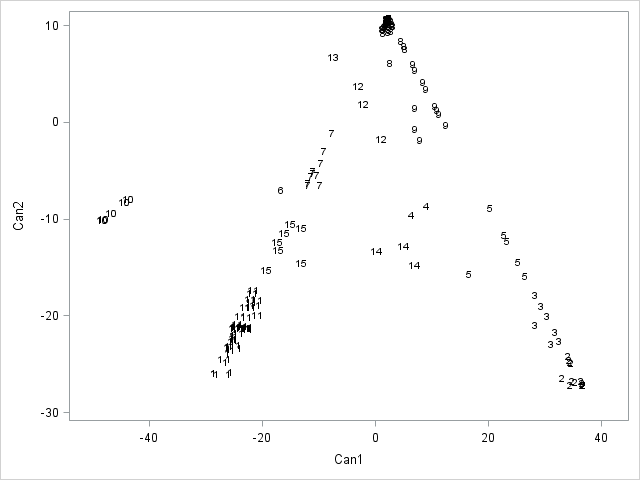

In [3]:
/**********************
more info on fastclus found here: https://documentation.sas.com/?docsetId=statug&docsetVersion=15.1&docsetTarget=statug_fastclus_overview.htm&locale=en
**********************/

/**********************
no standardization is needed prior to clustering, all vars measured on the same scale
**********************/

proc fastclus data=genetics1 out=Clust
              maxclusters=15 maxiter=100; /*tried clustering from 5 to 16; tried maxiter 100 and 1000 no difference*/
   var EUR EAS AMR SAS AFR;
run;

proc candisc data=clust out=genetics2;
var EUR EAS AMR SAS AFR;
class cluster;
run;

proc sgplot data=genetics2;
   scatter y=can2 x=can1 / markerchar=cluster;
run;


In [4]:
/**********************
post-cluster coding
**********************/

DATA genetics3;
    set genetics2;
    member="        ";
    if cluster=1  then member="AFR";
    if cluster=2  then member="AMR"; 
    if cluster=3  then member="AMRp";
    if cluster=4  then member="MIX";
    if cluster=5  then member="AMRp"; 
    if cluster=6  then member="MIX";
    if cluster=7  then member="EURp";
    if cluster=8  then member="EUR"; 
    if cluster=9  then member="EURp";
    if cluster=10 then member="EAS";
    if cluster=11 then member="AFRp"; 
    if cluster=12 then member="EURp";
    if cluster=13 then member="EURp";
    if cluster=14 then member="MIX"; 
    if cluster=15 then member="AFRp";
    
    
    alpha=.;
    if cluster=1  then alpha=1;
    if cluster=2  then alpha=1;
    if cluster=3  then alpha=.50;
    if cluster=4  then alpha=1;
    if cluster=5  then alpha=0.25; 
    if cluster=6  then alpha=1;
    if cluster=7  then alpha=0.25;
    if cluster=8  then alpha=1;
    if cluster=9  then alpha=0.50;
    if cluster=10 then alpha=1;
    if cluster=11 then alpha=0.50;
    if cluster=12 then alpha=0.50;
    if cluster=13 then alpha=0.50;
    if cluster=14 then alpha=1;
    if cluster=15 then alpha=0.25;
RUN;

Data genetics3;
    set genetics3;
    if corelabel^=member then flag=1;
run;
    

proc export 
  data=genetics3
  dbms=xlsx
  outfile="&location\data\npod_admix_results_v2.xlsx" 
  replace;
run;



PROC means data=genetics3 noprint nway n;
class CLUSTER member alpha;
var Can1;
output out=genetics3_can1 mean=Can1_mean;
run;

PROC means data=genetics3 noprint nway n;
class CLUSTER member alpha;
var Can2;
output out=genetics3_can2 mean=Can2_mean;
run;


DATA genetics4;
merge genetics3_can1 genetics3_can2;
by cluster;
rename _FREQ_=count;
run;


proc export 
  data=genetics4
  dbms=xlsx
  outfile="&location\data\npod_admix_results_v2_sum.xlsx" 
  replace;
run;



#### D.3 Statistical Analysis
Statistical testing was performed for differences in GRSs between non-diabetic and T1D individuals within each ancestry using a two-sample t test with a pooled or Satterthwaite corrected p-value if parametric, or the Kruskal-Wallis test if non-parametric. Normality testing was performed using the Shapiro Wilks method.  The Hodges-Lehmann estimation was used to obtain median differences and 95% CIs.  

Testing was performed using both the EUR GRS and AFR GRS. Multiple comparison corrections are denoted with an * within the main text and are only signficant at a nominal alpha of <0.025.  All reported p-values are 2-sided.    

In [5]:
/**********************
add demographics, GRS data analysis
**********************/

data genetics3;
    set genetics3;
    caseid=ID*1;
    id1=put(ID, 4.);
RUN;

PROC import out=demographics datafile = "&location\data\Demographics_2021-05-20_13-42-23.xlsx"
	DBMS = xlsx replace;
RUN;

DATA demographics; 
    set demographics; 
    id1=put('nPOD CaseID'n, 4.);
    rename 'Donor Type'n=donortype;
RUN;


DATA eurgrs1;
    set eurgrs;
    id1=put('nPOD CaseID'n, 4.);
RUN;

DATA eurgrs1 (keep = id1 grs1);
    set eurgrs1;
RUN;


DATA afrgrs1;
    set afrgrs;
    id1=put(FID, 4.);
RUN;

DATA afrgrs1 (keep = id1 grs);
set afrgrs1;
RUN;


PROC sort data=genetics3; by id1; run;
PROC sort data=demographics; by id1; run;
PROC sort data=eurgrs1; by id1; run;
PROC sort data=afrgrs1; by id1; run;

DATA all;
 merge genetics3 (in=a) demographics(in=b) eurgrs1 (in=c) afrgrs1(in=d);
 by id1;
 if a;
RUN;


proc export 
  data=all
  dbms=xlsx
  outfile="&location\data\data_for_figures_analysis_all.xlsx" 
  replace;
run;


DATA all2;
    SET ALL;
    if donortype^="T1D" and donortype^="No Diabetes" then delete;
    if member^="AFR" and member^="EUR" and member^="AMR" then delete;
run;

proc export 
  data=all2
  dbms=xlsx
  outfile="&location\data\data_for_figures_analysis_analyzed.xlsx" 
  replace;
run;


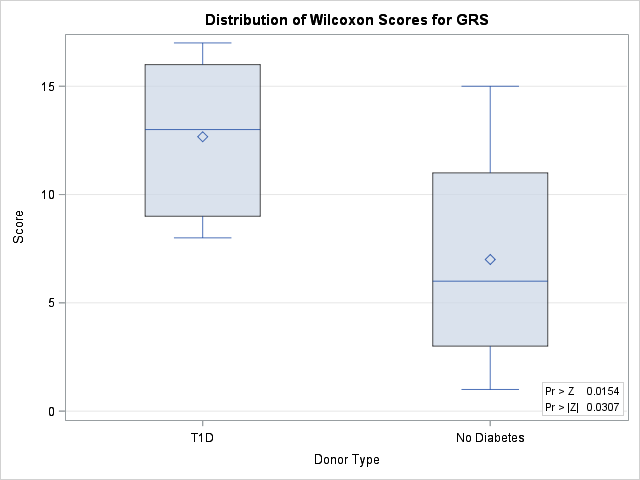
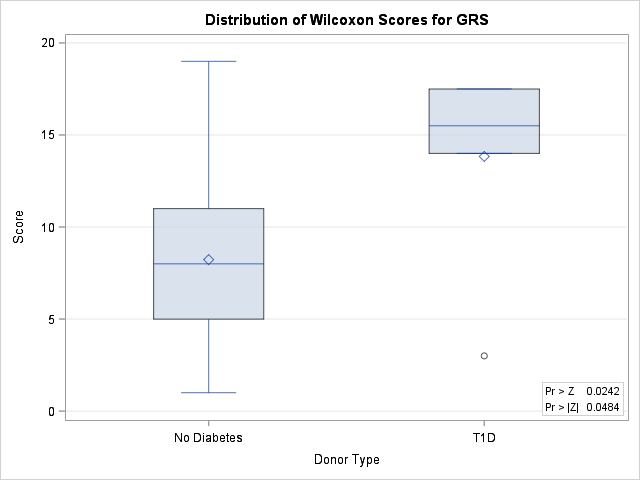
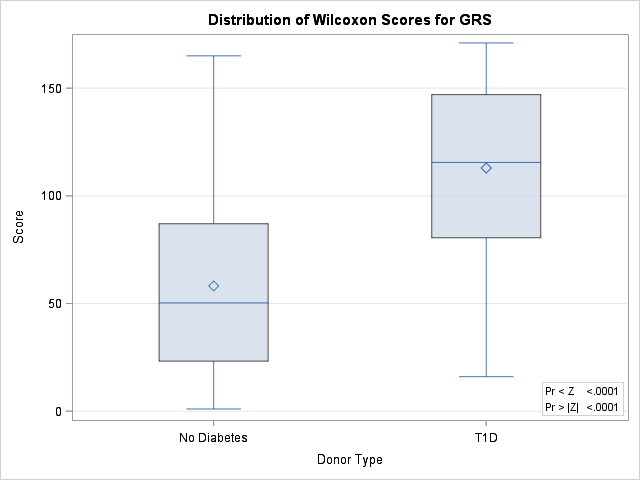

In [6]:
/**********************
differences in EUR GRS across ancestries
GRS is the AFR GRS
GRS1 is the EUR GRS
**********************/

proc sort data=ALL2; by member; run;
proc freq data=ALL2; tables donortype*member; run;
 proc NPAR1WAY data=all2 wilcoxon hl alpha=0.05; /*HL for hodges-lehmann estimates and alpha to set the CIs*/ 
	class donortype;
	var GRS;
     by member;
RUN;


In [13]:
proc freq data=all2;
tables member*donortype;
run;



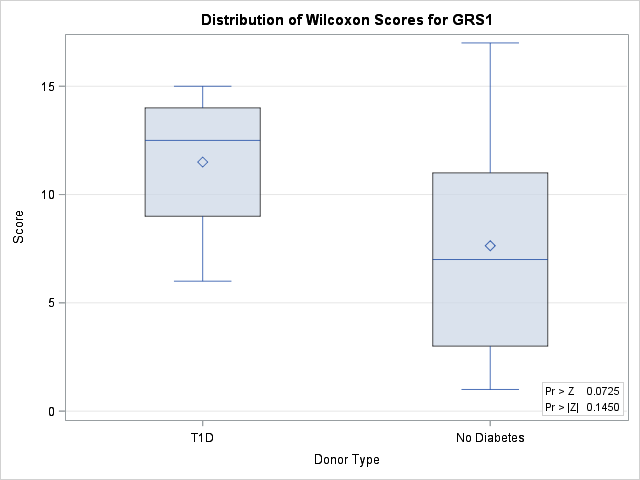
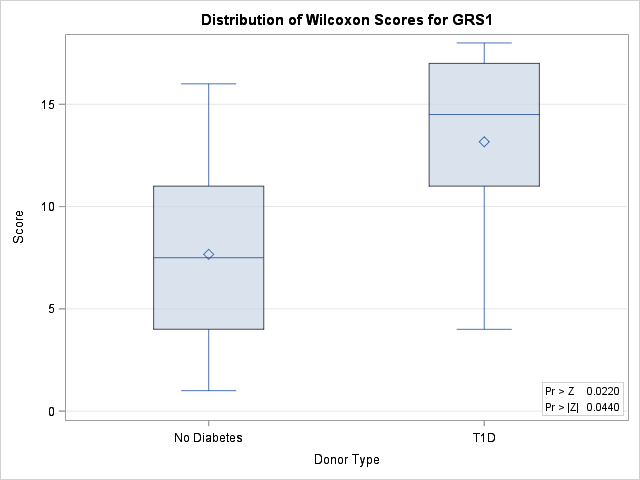
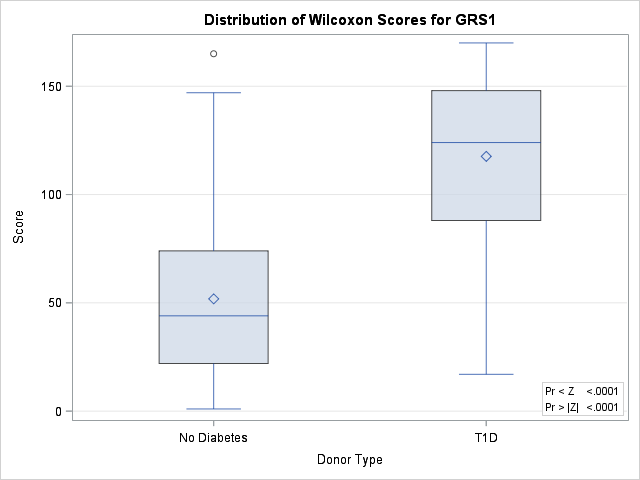

In [7]:
proc sort data=ALL2; by member; run;
proc freq data=ALL2; tables donortype*member; run;
 proc NPAR1WAY data=all2 wilcoxon hl alpha=0.05; /*HL for hodges-lehmann estimates and alpha to set the CIs*/ 
	class donortype;
	var GRS1;
     by member;
RUN;


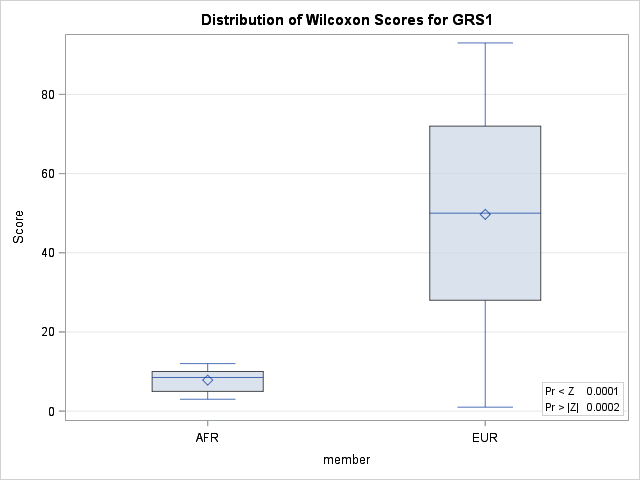
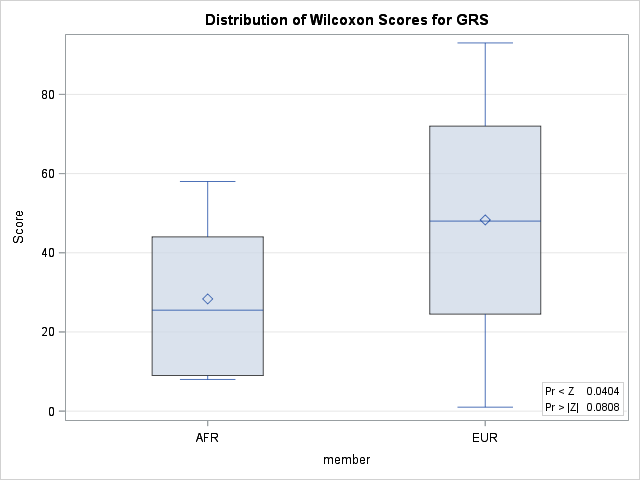

In [8]:
DATA special_comp;
set all2;
if member='AMR' then delete;
if donortype="No Diabetes" then delete;
run;

proc NPAR1WAY data=special_comp wilcoxon hl alpha=0.05; /*HL for hodges-lehmann estimates and alpha to set the CIs*/ 
	class member;
	var GRS1;
RUN;


proc NPAR1WAY data=special_comp wilcoxon hl alpha=0.05; /*HL for hodges-lehmann estimates and alpha to set the CIs*/ 
	class member;
	var GRS;
RUN;


### REFERENCES

1. Pugliese, A., et al. The Juvenile Diabetes Research Foundation Network for Pancreatic Organ Donors with Diabetes (nPOD) Program: goals, operational model and emerging findings. Pediatr Diabetes 15, 1-9 (2014).

2. Campbell-Thompson, M., et al. Network for Pancreatic Organ Donors with Diabetes (nPOD): developing a tissue biobank for type 1 diabetes. Diabetes Metab Res Rev 28, 608-617 (2012).

3. Carr, A.L.J., et al. Histological validation of a type 1 diabetes clinical diagnostic model for classification of diabetes. Diabetic Medicine 37, 2160-2168 (2020).

4. Cortes, A. & Brown, M.A. Promise and pitfalls of the Immunochip. Arthritis Research & Therapy 13, 101 (2011).

5. Onengut-Gumuscu, S., et al. Fine mapping of type 1 diabetes susceptibility loci and evidence for colocalization of causal variants with lymphoid gene enhancers. Nature Genetics 47, 381-386 (2015).

6. Type 1 Diabetes Genetic Risk Score: A Novel Tool to Discriminate Monogenic and Type 1 Diabetes. Diabetes 65, 2094-2099 (2016).

7. Oram, R.A., et al. A Type 1 Diabetes Genetic Risk Score Can Aid Discrimination Between Type 1 and Type 2 Diabetes in Young Adults. Diabetes Care 39, 337-344 (2016).

8. Onengut-Gumuscu, S., et al. Type 1 Diabetes Risk in African-Ancestry Participants and Utility of an Ancestry-Specific Genetic Risk Score. Diabetes Care 42, 406-415 (2019).

9. Alexander, D.H., Novembre, J. & Lange, K. Fast model-based estimation of ancestry in unrelated individuals. Genome Res 19, 1655-1664 (2009).

10. Auton, A., et al. A global reference for human genetic variation. Nature 526, 68-74 (2015).
